### Calculate global tropospheric burdens, CH4 lifetime and NH/SH air mass averaged tropospheric OH ratio

In [1]:
import datetime
import warnings
from pathlib import Path

import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from pandas.plotting import register_matplotlib_converters
from scipy import stats

In [2]:
from util_commons import EXPERIMENTS, GASES
from util_mypaths import path_to_processed, path_to_raw, path_to_results
from util_plot_func import use_draft_style

In [3]:
warnings.filterwarnings("ignore", module="iris")
register_matplotlib_converters()  # for tstamps
use_draft_style()

In [4]:
# Switches
trop_def = "chemical"  # diagnostic or chemical
S60N60 = False  # True or False

In [5]:
def calc_burden(cube):
    """Calculate the global tropospheric burden of a selected species."""
    burden = (cube * air_mass * trop_mask).collapsed(
        ["latitude", "longitude", "level_height"], iris.analysis.SUM
    )
    if cube.name() in ["meono2", "etono2", "nprono2", "iprono2"]:
        burden.convert_units("Gg")
    else:
        burden.convert_units("Tg")
    burden.rename(cube.name() + " global tropospheric burden")
    return burden

In [6]:
def calc_stats(cube):
    """Calculate the annual mean, standard deviation and standard error of the mean."""
    mean = np.mean(cube.data[t0:t1].reshape(used_yrs, 12).mean(axis=1))  # annual mean
    std = np.std(cube.data[t0:t1])
    sem = stats.sem(cube.data[t0:t1], axis=0, ddof=0)
    # Note: I used cube.data[[*range(4)] + [*range(7, 8)]] for FIRE OLD to exclude faulty data
    return (mean, std, sem)

In [7]:
def plt_time_series(cube):
    fig, ax = plt.subplots()
    ax.plot(tstamps[: t0 + 1], cube.data[: t0 + 1], color="b", label="spin-up")
    ax.plot(tstamps[t0:t1], cube.data[t0:t1], color="g", label="used")

    ngas = cube.name().split(" ")[0]

    if cube.name() == "ch4 global tropospheric lifetime":
        metric = "lifetime"
    else:
        metric = "burden"

    ax.set_title(f"{exp}\n", loc="left", weight="bold")
    ax.set_title(
        f"Tropospheric {GASES[ngas]['tex']} {metric}\n({S60N60_tex}using {trop_tex})", loc="right",
    )
    ax.set_xlabel("Time, yr")
    ax.set_ylabel(cube.units)

    # Format xticklabels to show years since the start of the simulation
    iris.coord_categorisation.add_year(cube, "time", name="year")
    iris.coord_categorisation.add_month(cube, "time", name="month")
    plt.draw()
    ticks_labels = [
        int(i.get_text()) - cube.coord("year").points[0] for i in ax.get_xticklabels(which="both")
    ]
    ticks_locs = ax.get_xticks().tolist()
    ax.set_xticks(ticks_locs)
    ax.set_xticklabels(ticks_labels)

    ax.legend(loc="lower right", frameon=False)

    figname = "_".join([i for i in [EXPERIMENTS[exp], ngas, metric, trop_str, S60N60_str] if i])


#     fig.savefig(path_to_results / EXPERIMENTS[exp] / "metrics" / figname)

/home/maria/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


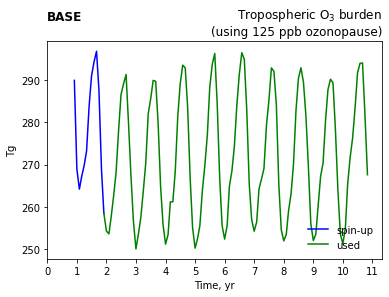

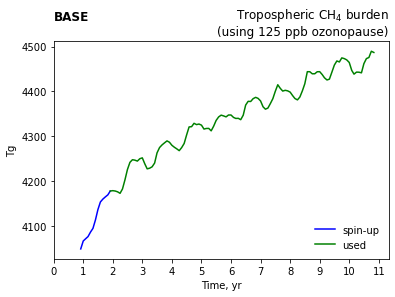

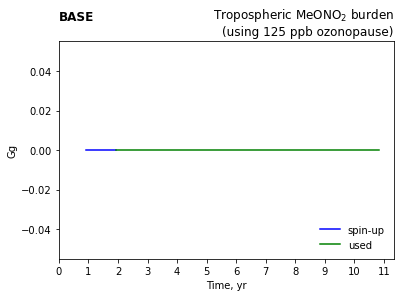

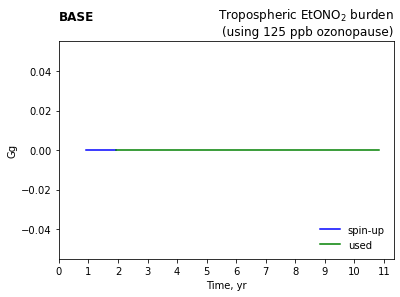

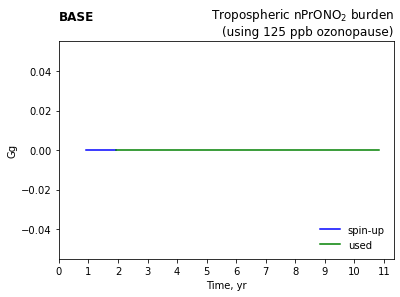

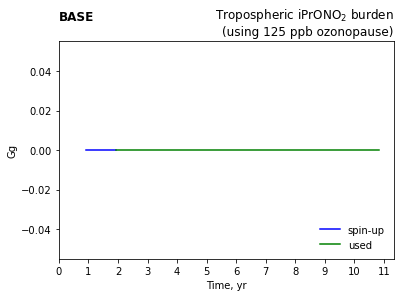

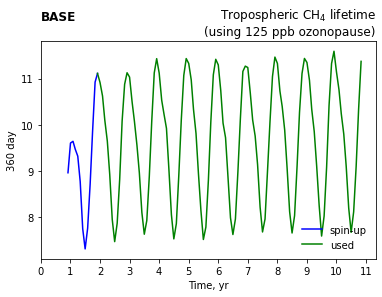

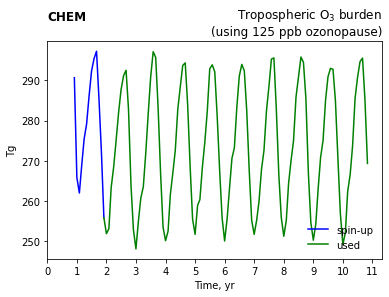

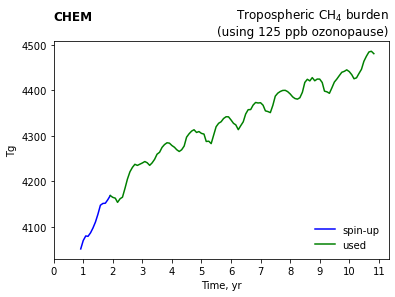

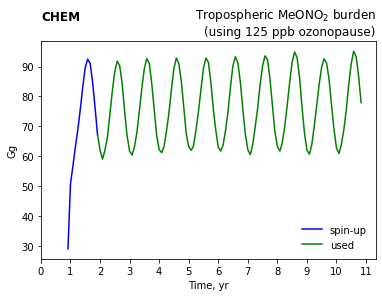

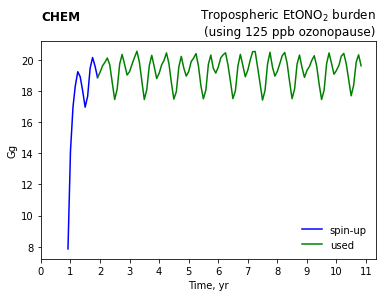

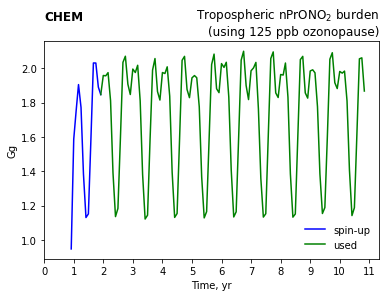

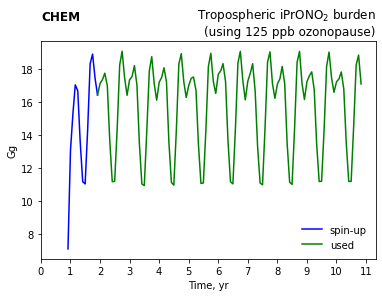

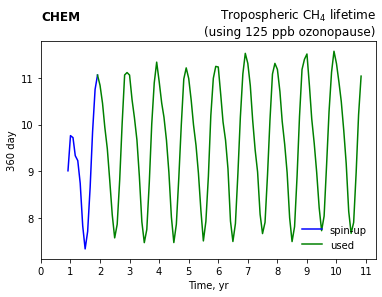

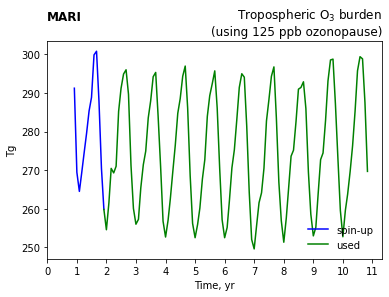

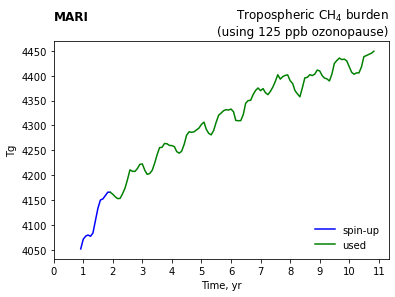

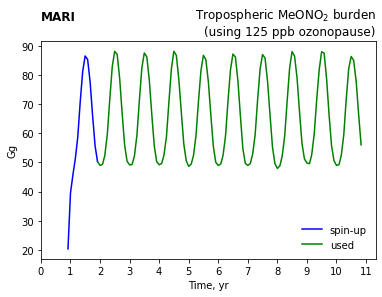

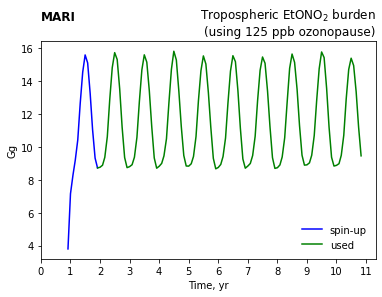

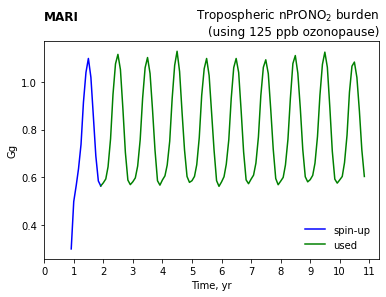

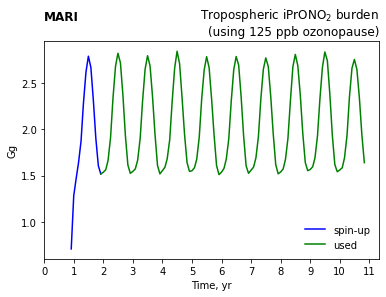

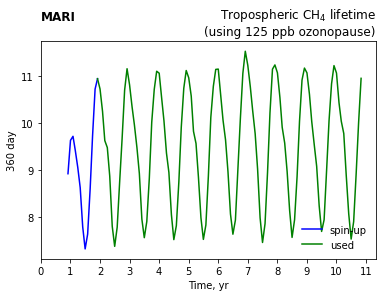

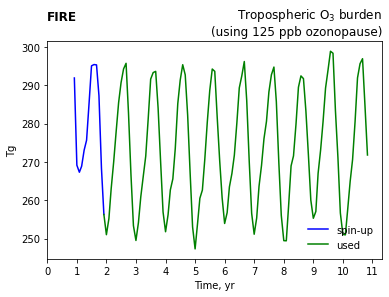

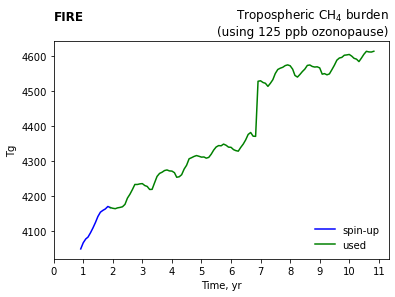

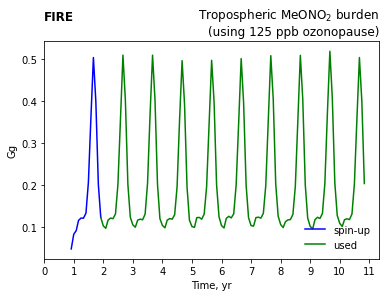

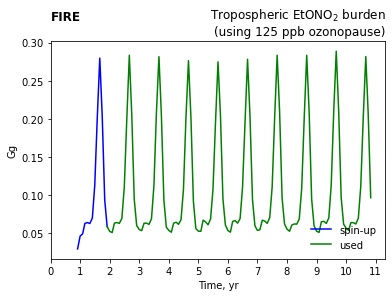

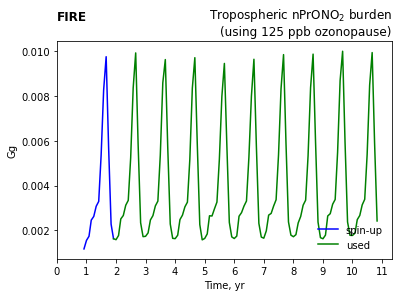

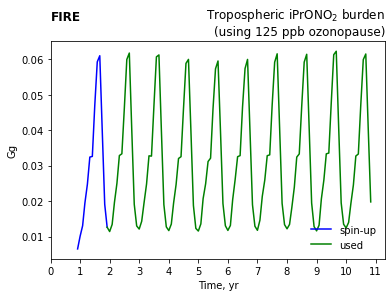

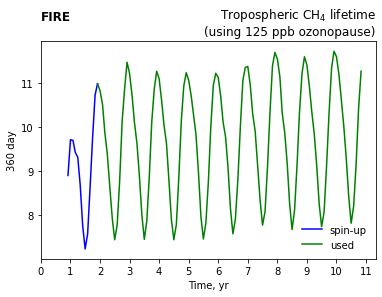

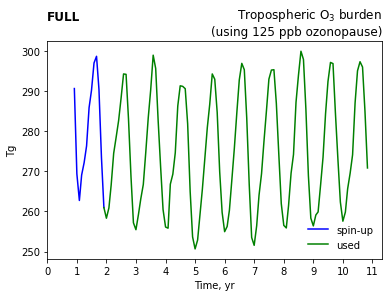

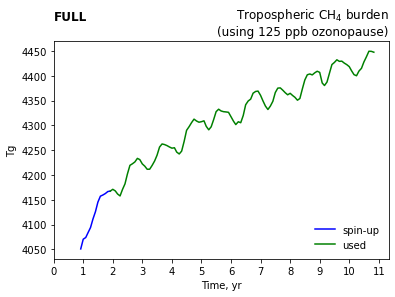

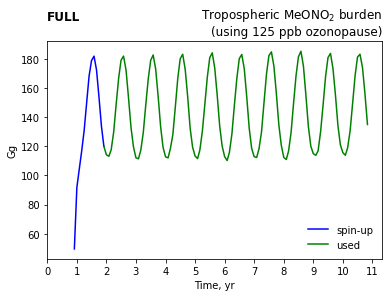

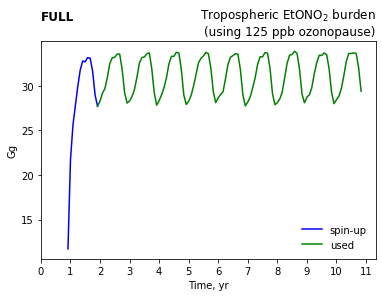

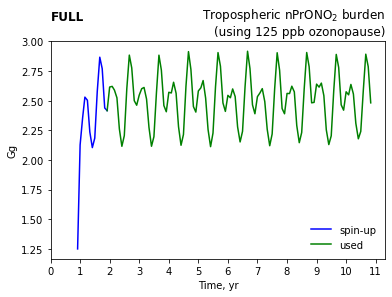

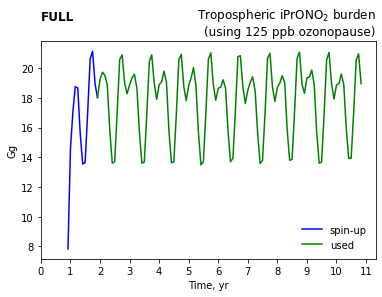

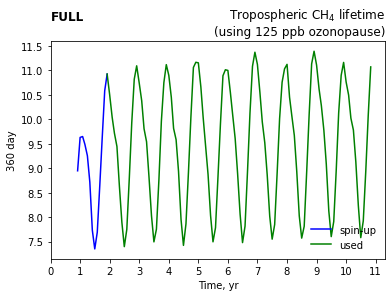

In [8]:
TABLE = {}  # TABLE is a summary table
for exp in EXPERIMENTS.keys():
    # Load data
    path_to_exp = path_to_processed / EXPERIMENTS[exp]
    o3 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_o3.nc"))
    oh = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_oh.nc"))
    ch4 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_ch4.nc"))
    temp = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_temp.nc"))
    air_mass = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_air_mass.nc"))
    gridbox_vol = iris.load_cube(str(path_to_raw / "ukca_n48_l60_geovol.nc"), "vol_theta")
    meono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_meono2.nc"))
    etono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_etono2.nc"))
    nprono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_nprono2.nc"))
    iprono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_iprono2.nc"))
    air_mass.units = "kg"
    gridbox_vol.units = "m3"
    iprono2.units = "kg kg-1"

    # Consider the first year as a spin-up
    used_yrs = 9
    t0, t1 = 12, 120

    # Define troposphere
    if trop_def == "diagnostic":
        # Use tropospheric mask fraction [unitless]
        trop_mask = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_trop_mask.nc"))
        trop_tex = "tropospheric mask fraction"
        trop_str = "tropdiag"
    elif trop_def == "chemical":
        # One where O3 is less than 125 ppb
        molar_mass_air = iris.coords.AuxCoord(GASES["air"]["molar_mass"], units="g mol-1")
        molar_mass_o3 = iris.coords.AuxCoord(GASES["o3"]["molar_mass"], units="g mol-1")
        coeff_o3 = molar_mass_air.points[0] / molar_mass_o3.points[0] * 1e9
        trop_mask_bool = np.ma.masked_less(o3.data * coeff_o3, 125).mask
        trop_mask = o3.copy(data=trop_mask_bool)
        trop_mask.rename("chemical troposphere")
        trop_tex = "125 ppb ozonopause"
        trop_str = "tropchem"
        trop_mask.units = "1"

    # Define 60S-60N region for comparison with TOAR
    if S60N60:
        S60N60_constraint = iris.Constraint(latitude=lambda cell: -60 <= cell <= 60)
        o3 = o3.extract(S60N60_constraint)
        oh = oh.extract(S60N60_constraint)
        ch4 = ch4.extract(S60N60_constraint)
        temp = temp.extract(S60N60_constraint)
        air_mass = air_mass.extract(S60N60_constraint)
        trop_mask = trop_mask.extract(S60N60_constraint)
        gridbox_vol = gridbox_vol.extract(S60N60_constraint)
        if exp in ["CHEM", "MARI", "FIRE", "FULL"]:
            meono2 = meono2.extract(S60N60_constraint)
            etono2 = etono2.extract(S60N60_constraint)
            nprono2 = nprono2.extract(S60N60_constraint)
            iprono2 = iprono2.extract(S60N60_constraint)
        S60N60_tex = "60\u00B0S-60\u00B0N "
        S60N60_str = "60S60N"
    else:
        S60N60_tex = ""
        S60N60_str = ""

    # Create datetime coordinate for plotting
    cb = o3.copy()
    iris.coord_categorisation.add_year(cb, "time", name="year")
    iris.coord_categorisation.add_month(cb, "time", name="month")
    tstamp0 = datetime.datetime.strptime(
        f"{cb.coord('year').points[0]} " + cb.coord("month").points[0], "%Y %b"
    )
    tstamp1 = tstamp0 + relativedelta(years=9, months=11)
    tstamps = pd.date_range(tstamp0, tstamp1, freq="MS")

    ## Calculate CH4 lifetime
    # Constants
    k_ch4_oh = temp.copy(data=1.85e-12 * np.exp(-1690 / temp.data))
    k_ch4_oh.rename("CH4+OH reaction rate coefficient")
    k_ch4_oh.units = "cm3 s-1"
    molar_mass_oh = iris.coords.AuxCoord(GASES["oh"]["molar_mass"], units="g mol-1")
    molar_mass_ch4 = iris.coords.AuxCoord(GASES["ch4"]["molar_mass"], units="g mol-1")
    avogadro_number = iris.coords.AuxCoord(6.022 * 1e23, units="mol-1", long_name="avogadro_number")
    # Find the number of OH and CH4 molecules per grid box (tropospheric burden in molecules, not kg)
    oh_molecules_per_gridbox = oh * air_mass * trop_mask / molar_mass_oh * avogadro_number
    ch4_molecules_per_gridbox = ch4 * air_mass * trop_mask / molar_mass_ch4 * avogadro_number
    # Prepare gridbox_vol cube for a later multiplication by oh_molecules_per_gridbox cube
    # Get rid of the time coordinate
    gridbox_vol = iris.util.squeeze(gridbox_vol)
    gridbox_vol.remove_coord("t")
    # Copy oh_molecules_per_gridbox metadata to gridbox_vol cube
    _var_name, _units = gridbox_vol.var_name, gridbox_vol.units
    gridbox_vol = oh_molecules_per_gridbox[0, ...].copy(data=gridbox_vol.data)
    gridbox_vol.rename(_var_name)
    gridbox_vol.units = _units
    gridbox_vol.remove_coord("forecast_reference_time")
    # Calculate CH4 loss in molecules s-1
    loss_ch4_oh = k_ch4_oh * ch4_molecules_per_gridbox * oh_molecules_per_gridbox / gridbox_vol
    # Calculate CH4 lifetime
    volume_sum = (["latitude", "longitude", "level_height"], iris.analysis.SUM)
    ch4_lifetime = ch4_molecules_per_gridbox.collapsed(*volume_sum) / loss_ch4_oh.collapsed(
        *volume_sum
    )
    ch4_lifetime.rename("ch4 global tropospheric lifetime")
    ch4_lifetime.convert_units("360 day")

    ## Calculate NH/SH air mass averaged tropospheric OH ratio
    # Calculate OH in molecules per cm3
    oh_molecules_per_cm3 = oh_molecules_per_gridbox / gridbox_vol
    oh_molecules_per_cm3.convert_units("cm-3")
    # Weight OH in each hemisphere by the mass of air in each hemisphere
    nh_constraint = iris.Constraint(latitude=lambda x: x >= 0)
    sh_constraint = iris.Constraint(latitude=lambda x: x <= 0)
    global_constraint = (["longitude", "latitude", "level_height"], iris.analysis.MEAN)
    oh_nh = (oh_molecules_per_cm3 * air_mass).extract(nh_constraint).collapsed(
        *global_constraint
    ) / air_mass.extract(nh_constraint).collapsed(*global_constraint)
    oh_sh = (oh_molecules_per_cm3 * air_mass).extract(sh_constraint).collapsed(
        *global_constraint
    ) / air_mass.extract(sh_constraint).collapsed(*global_constraint)
    nh_to_sh_oh_ratio = oh_nh / oh_sh
    nh_to_sh_oh_ratio.rename("NH/SH tropospheric OH ratio")

    # Populate a summary table
    TABLE[exp] = {}
    for var in o3, ch4, meono2, etono2, nprono2, iprono2:
        TABLE[exp][var.name()] = {
            "units": str(calc_burden(var).units),
            "mean": calc_stats(calc_burden(var))[0],
            "std": calc_stats(calc_burden(var))[1],
            "sem": calc_stats(calc_burden(var))[2],
        }
    TABLE[exp][r"tau ch4"] = {
        "units": "yr",
        "mean": calc_stats(ch4_lifetime)[0],
        "std": calc_stats(ch4_lifetime)[1],
        "sem": calc_stats(ch4_lifetime)[2],
    }
    TABLE[exp][r"NH/SH OH"] = {
        "units": "",
        "mean": calc_stats(nh_to_sh_oh_ratio)[0],
        "std": calc_stats(nh_to_sh_oh_ratio)[1],
        "sem": calc_stats(nh_to_sh_oh_ratio)[2],
    }

    # Plot time series
    for gas in o3, ch4, meono2, etono2, nprono2, iprono2:
        plt_time_series(calc_burden(gas))
    plt_time_series(ch4_lifetime)

In [9]:
# Add more metrics into a summary table
for exp in [i for i in EXPERIMENTS.keys() if i != "BASE"]:
    for varname, vardict in TABLE[exp].items():
        # Calculate absolute differences in the annual mean burden and the standard error of the mean
        TABLE[exp][varname]["mean_diff_abs"] = vardict["mean"] - TABLE["BASE"][varname]["mean"]
        TABLE[exp][varname]["sem_err_abs"] = np.sqrt(
            vardict["sem"] ** 2 + TABLE["BASE"][varname]["sem"] ** 2
        )
        # Calculate relative differences in the annual mean burden and the standard error of the mean
        # If BASE's mean is zero or very close to zero, do not calculate relative differences
        if abs(TABLE["BASE"][varname]["mean"]) > 1e-14:
            TABLE[exp][varname]["mean_diff_rel"] = 100 * (
                (TABLE[exp][varname]["mean_diff_abs"]) / TABLE["BASE"][varname]["mean"]
            )
            TABLE[exp][varname]["sem_err_rel"] = 100 * (
                (TABLE[exp][varname]["sem_err_abs"]) / TABLE["BASE"][varname]["mean"]
            )

In [10]:
pd.DataFrame.from_dict(TABLE, orient="index")

,o3,ch4,meono2,etono2,nprono2,iprono2,tau ch4,NH/SH OH
BASE,"{'units': 'Tg', 'mean': 271.74176, 'std': 14.5...","{'units': 'Tg', 'mean': 4349.913, 'std': 84.66...","{'units': 'Gg', 'mean': 0.0, 'std': 0.0, 'sem'...","{'units': 'Gg', 'mean': 0.0, 'std': 0.0, 'sem'...","{'units': 'Gg', 'mean': 0.0, 'std': 0.0, 'sem'...","{'units': 'Gg', 'mean': 0.0, 'std': 0.0, 'sem'...","{'units': 'yr', 'mean': 9.681340408150842, 'st...","{'units': '', 'mean': 1.603906821079013, 'std'..."
CHEM,"{'units': 'Tg', 'mean': 273.09576, 'std': 15.2...","{'units': 'Tg', 'mean': 4337.646, 'std': 82.29...","{'units': 'Gg', 'mean': 76.50557, 'std': 11.45...","{'units': 'Gg', 'mean': 19.34826, 'std': 0.878...","{'units': 'Gg', 'mean': 1.740191, 'std': 0.324...","{'units': 'Gg', 'mean': 15.875872, 'std': 2.60...","{'units': 'yr', 'mean': 9.618737216853495, 'st...","{'units': '', 'mean': 1.5874781032292562, 'std..."
MARI,"{'units': 'Tg', 'mean': 274.66797, 'std': 14.8...","{'units': 'Tg', 'mean': 4325.035, 'std': 82.64...","{'units': 'Gg', 'mean': 65.67856, 'std': 14.29...","{'units': 'Gg', 'mean': 11.556798, 'std': 2.52...","{'units': 'Gg', 'mean': 0.7924098, 'std': 0.19...","{'units': 'Gg', 'mean': 2.051754, 'std': 0.464...","{'units': 'yr', 'mean': 9.53468539766829, 'std...","{'units': '', 'mean': 1.5714309454969035, 'std..."
FIRE,"{'units': 'Tg', 'mean': 273.44272, 'std': 15.1...","{'units': 'Tg', 'mean': 4407.642, 'std': 151.9...","{'units': 'Gg', 'mean': 0.20743188, 'std': 0.1...","{'units': 'Gg', 'mean': 0.10992284, 'std': 0.0...","{'units': 'Gg', 'mean': 0.004041156, 'std': 0....","{'units': 'Gg', 'mean': 0.03127816, 'std': 0.0...","{'units': 'yr', 'mean': 9.703851850037772, 'st...","{'units': '', 'mean': 1.5971069177370747, 'std..."
FULL,"{'units': 'Tg', 'mean': 274.9626, 'std': 14.54...","{'units': 'Tg', 'mean': 4323.818, 'std': 77.44...","{'units': 'Gg', 'mean': 144.46078, 'std': 25.8...","{'units': 'Gg', 'mean': 31.112436, 'std': 2.11...","{'units': 'Gg', 'mean': 2.5084631, 'std': 0.21...","{'units': 'Gg', 'mean': 17.925621, 'std': 2.31...","{'units': 'yr', 'mean': 9.523777718394038, 'st...","{'units': '', 'mean': 1.5774444542370827, 'std..."


In [11]:
pd.DataFrame.from_dict(TABLE["BASE"])

,o3,ch4,meono2,etono2,nprono2,iprono2,tau ch4,NH/SH OH
units,Tg,Tg,Gg,Gg,Gg,Gg,yr,
mean,271.742,4349.91,0,0,0,0,9.68134,1.60391
std,14.5162,84.6668,0,0,0,0,1.28394,0.988248
sem,1.39682,8.14707,0,0,0,0,0.123547,0.0950942


In [12]:
pd.DataFrame.from_dict(TABLE["FULL"])

,o3,ch4,meono2,etono2,nprono2,iprono2,tau ch4,NH/SH OH
units,Tg,Tg,Gg,Gg,Gg,Gg,yr,
mean,274.963,4323.82,144.461,31.1124,2.50846,17.9256,9.52378,1.57744
std,14.5487,77.4479,25.8075,2.11873,0.214294,2.31971,1.22754,0.971202
sem,1.39995,7.45243,2.48333,0.203875,0.0206204,0.223214,0.11812,0.093454
mean_diff_abs,3.22083,-26.0952,144.461,31.1124,2.50846,17.9256,-0.157563,-0.0264624
sem_err_abs,1.97761,11.0414,2.48333,0.203875,0.0206204,0.223214,0.170928,0.133329
mean_diff_rel,1.18525,-0.599902,NaN,NaN,NaN,NaN,-1.62749,-1.64987
sem_err_rel,0.727755,0.253831,NaN,NaN,NaN,NaN,1.76554,8.31275


In [14]:
DISPLAY1 = {}
for exp in EXPERIMENTS.keys():
    DISPLAY1[exp] = {}
    for i in ["o3", "ch4", "tau ch4", "NH/SH OH"]:
        DISPLAY1[exp][i] = f"{TABLE[exp][i]['mean']:1.3f} ({TABLE[exp][i]['sem']:1.3f})"
pd.DataFrame.from_dict(DISPLAY1, orient="index")

,o3,ch4,tau ch4,NH/SH OH
BASE,271.742 (1.397),4349.913 (8.147),9.681 (0.124),1.604 (0.095)
CHEM,273.096 (1.463),4337.646 (7.919),9.619 (0.122),1.587 (0.094)
MARI,274.668 (1.429),4325.035 (7.953),9.535 (0.118),1.571 (0.093)
FIRE,273.443 (1.462),4407.642 (14.619),9.704 (0.125),1.597 (0.094)
FULL,274.963 (1.400),4323.818 (7.452),9.524 (0.118),1.577 (0.093)


In [15]:
DISPLAY2 = {}
for exp in [i for i in EXPERIMENTS.keys() if i != "BASE"]:
    DISPLAY2[exp] = {}
    for i in ["meono2", "etono2", "nprono2", "iprono2"]:
        DISPLAY2[exp][i] = f"{TABLE[exp][i]['mean']:1.3f} ({TABLE[exp][i]['sem']:1.3f})"
pd.DataFrame.from_dict(DISPLAY2, orient="index")

,meono2,etono2,nprono2,iprono2
CHEM,76.506 (1.102),19.348 (0.085),1.740 (0.031),15.876 (0.250)
MARI,65.679 (1.376),11.557 (0.243),0.792 (0.019),2.052 (0.045)
FIRE,0.207 (0.013),0.110 (0.007),0.004 (0.000),0.031 (0.002)
FULL,144.461 (2.483),31.112 (0.204),2.508 (0.021),17.926 (0.223)


In [16]:
DISPLAY3 = {}
for exp in [i for i in EXPERIMENTS.keys() if i != "BASE"]:
    DISPLAY3[exp] = {}
    for i in ["o3", "tau ch4"]:
        DISPLAY3[exp][
            i
        ] = f"{TABLE[exp][i]['mean_diff_rel']:1.2f} ({TABLE[exp][i]['sem_err_rel']:1.2f})"
pd.DataFrame.from_dict(DISPLAY3, orient="index")

,o3,tau ch4
CHEM,0.50 (0.74),-0.65 (1.80)
MARI,1.08 (0.74),-1.51 (1.77)
FIRE,0.63 (0.74),0.23 (1.81)
FULL,1.19 (0.73),-1.63 (1.77)


In [17]:
pd.DataFrame.from_dict(DISPLAY3, orient="index").to_latex()

'\\begin{tabular}{lll}\n\\toprule\n{} &           o3 &       tau ch4 \\\\\n\\midrule\nCHEM &  0.50 (0.74) &  -0.65 (1.80) \\\\\nMARI &  1.08 (0.74) &  -1.51 (1.77) \\\\\nFIRE &  0.63 (0.74) &   0.23 (1.81) \\\\\nFULL &  1.19 (0.73) &  -1.63 (1.77) \\\\\n\\bottomrule\n\\end{tabular}\n'